In [215]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

### Preparacion de los datos

In [216]:
df_tracks = pd.read_csv('2000-2022_all_tracks_final.csv', encoding='utf-8')

In [217]:
# eliminando columna id que esta duplicada con columna track_id
df_tracks.drop(columns=['id'], axis=1, inplace=True)

In [218]:
# eliminando tracks con caracteristicas nulas
df_tracks = df_tracks[~df_tracks['danceability'].isnull()]

In [219]:
# eliminando registros de tracks con popularidad 0 porque tiene un numero mayor al resto de popularidad
import random
df_tracks_0 = df_tracks[df_tracks['popularity_track'] == 0].sample(n=150, random_state=1)
df_tracks_resto = df_tracks[(df_tracks['popularity_track'] > 0)]
df_tracks = pd.concat([df_tracks_0, df_tracks_resto])

In [220]:
df_tracks['release_year'] = df_tracks['release_date'].str[0:4]
df_tracks['release_year'] = df_tracks['release_year'].astype('int')

In [221]:
#listado de columnas a incluir en el modelo
col_caract = ['danceability', 'duration_ms', 'energy', 'instrumentalness', 'speechiness', 'liveness', 'explicit', 'key', 
       'loudness', 'mode', 'valence', 'tempo', 'time_signature', 'followers_artist_1', 'release_year']

In [222]:
#Tranformando variables categoricas
df_tracks['key'] = df_tracks['key'].astype('category')
df_tracks['mode'] = df_tracks['mode'].astype('category')
df_tracks['time_signature'] = df_tracks['time_signature'].astype('category')

In [223]:
df_tracks_tmp = pd.get_dummies(df_tracks[col_caract])

In [224]:
# cambiado duracion a minutos 
df_tracks_tmp['duration_m'] = round(df_tracks_tmp['duration_ms']/60000, 2)

# eliminando duracion en milisegundos
df_tracks_tmp.drop(['duration_ms'], axis=1, inplace=True)


In [225]:
#Escalando variables 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(copy= True, with_mean=True, with_std=True)
df_scaler = scaler.fit_transform(df_tracks_tmp)

### Modelos de Regresión
en esta seccion se aplicara modelo de regresion para la prediccion de popularidad

In [135]:
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

#### Diviendo dataset en Train y Test

In [136]:
from sklearn.model_selection import train_test_split

X = df_scaler
y = df_tracks['popularity_track']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((4686, 31), (1172, 31), (4686,), (1172,))

#### Linear Regression

In [137]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.40404368775964894

In [138]:
y_test_pred = lr.predict(X_test)
y_train_pred = lr.predict(X_train)

print(f'Score de train:{lr.score(X_train, y_train): .2f}')
print(f'Score de test:{lr.score(X_test, y_test): .2f}')

Score de train: 0.45
Score de test: 0.40


#### Regresion Lineal - Cross Validation

In [139]:
from sklearn.model_selection import cross_val_score
from sklearn import datasets, linear_model

linreg = LinearRegression()
linreg.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score
from sklearn import datasets, linear_model

scores = cross_val_score(linreg, X_train, y_train, cv=5)
print(scores)

[0.45166621 0.42122318 0.47537187 0.40541311 0.44388845]


#### Decision Tree Regressor

In [140]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

reg_tree = DecisionTreeRegressor().fit(X_train, y_train)
reg_tree.score(X_test, y_test)

0.18009130076807933

In [141]:
reg_ = GridSearchCV(
        DecisionTreeRegressor(), 
        param_grid={'max_depth': [3, 5],
                'min_samples_leaf': [3, 10, 15, 20, 30]
                }).fit(X_train, y_train)

In [142]:
reg_.best_score_

0.5433818498920032

In [143]:
reg_.best_params_

{'max_depth': 5, 'min_samples_leaf': 30}

In [144]:
y_test_pred = reg_.predict(X_test)
y_train_pred = reg_.predict(X_train)

print(f'Score de train:{reg_.score(X_train, y_train): .2f}')
print(f'Score de test:{reg_.score(X_test, y_test): .2f}')

Score de train: 0.58
Score de test: 0.51


#### Gradient Boosting Regressor

In [145]:
from sklearn.ensemble import GradientBoostingRegressor

reg_gbr = GradientBoostingRegressor().fit(X_train, y_train)
reg_gbr.score(X_test, y_test)

0.601319546165018

In [146]:
reg_ = GridSearchCV(
       GradientBoostingRegressor(),
       param_grid = { 'max_depth': [3, 5],
                      'min_samples_leaf': [3, 10, 15, 20, 30]
       }).fit(X_train, y_train)

In [147]:
reg_.best_params_

{'max_depth': 5, 'min_samples_leaf': 20}

In [148]:
reg_.best_score_

0.6252308420089375

In [149]:
y_test_pred = reg_.predict(X_test)
y_train_pred = reg_.predict(X_train)

print(f'Score de train:{reg_.score(X_train, y_train): .2f}')
print(f'Score de test:{reg_.score(X_test, y_test): .2f}')

Score de train: 0.76
Score de test: 0.62


### Modelos de Clasificacion    

In [228]:
df_tracks_tmp.head()

,danceability,energy,instrumentalness,speechiness,liveness,explicit,loudness,valence,tempo,followers_artist_1,release_year,key_0.0,key_1.0,key_2.0,key_3.0,key_4.0,key_5.0,key_6.0,key_7.0,key_8.0,key_9.0,key_10.0,key_11.0,mode_0.0,mode_1.0,time_signature_0.0,time_signature_1.0,time_signature_3.0,time_signature_4.0,time_signature_5.0,duration_m
2233,0.878,0.575,0.00000,0.2840,0.2730,True,-8.732,0.3990,144.918,4939478,2022,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,3.09
5488,0.475,0.262,0.77300,0.0407,0.0749,False,-21.722,0.2500,123.242,1957,2001,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1.62
3371,0.227,0.247,0.95900,0.0364,0.1140,False,-20.318,0.0374,73.590,4900,2017,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1.10
4422,0.713,0.804,0.00226,0.0646,0.1020,True,-4.487,0.4300,149.911,10,2021,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,2.04
1136,0.769,0.719,0.00777,0.0474,0.3590,True,-5.472,0.8630,121.955,925826,2020,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,2.95


In [229]:
pd.cut(df_tracks['popularity_track'], bins=3, labels = ["0", "1", "2"]).value_counts()

0    2729
2    1806
1    1323
Name: popularity_track, dtype: int64

In [230]:
# conviertiendo variable target a categorica, se crearn 3 grupos de popularidad
df_tracks['popularity_track_cat'] = pd.cut(df_tracks['popularity_track'], bins=3, labels = ["0", "1", "2"], right = True)

<AxesSubplot:>

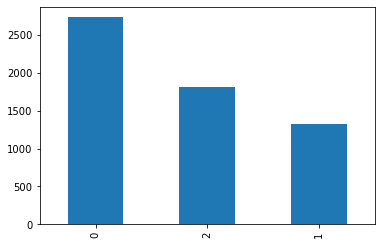

In [231]:
df_tracks['popularity_track_cat'].value_counts().plot(kind='bar')

In [232]:
df_tracks[['popularity_track_cat', 'popularity_track']].groupby(by=['popularity_track_cat']).agg(['min', 'max'])

popularity_track    
                                  min max
popularity_track_cat                     
0                                   0  31
1                                  32  63
2                                  64  95

In [233]:
X = df_scaler
y = df_tracks['popularity_track_cat']

In [234]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X, y)

(X_ros.shape, y_ros.shape)

((8187, 31), (8187,))

<AxesSubplot:>

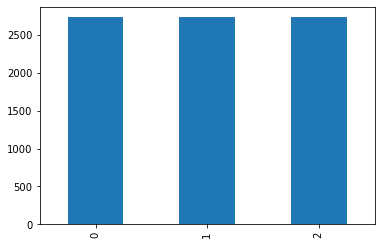

In [235]:
y_ros.value_counts().plot(kind='bar')

In [236]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, test_size=0.2,random_state=42)
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((6549, 31), (1638, 31), (6549,), (1638,))

#### KNeighbors Classifier

In [203]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [204]:
y_test_pred = knn.predict(X_test)
y_train_pred = knn.predict(X_train)

In [205]:
print(f'Score de train:{knn.score(X_train, y_train): .2f}')
print(f'Score de test:{knn.score(X_test, y_test): .2f}')

Score de train: 0.76
Score de test: 0.63


#### Decission Tree Classifier

In [162]:
from sklearn.tree import DecisionTreeClassifier

clf_tree = DecisionTreeClassifier().fit(X_train, y_train)
clf_tree.score(X_test, y_test)

0.8003663003663004

In [163]:
clf_ = GridSearchCV(
        DecisionTreeClassifier(),
        param_grid= {'max_depth': [3, 5, 8],
                     'min_samples_leaf': [3, 10, 20, 50]
        }).fit(X_train, y_train)

In [164]:
clf_.best_score_

0.6697199073939084

In [165]:
clf_.best_params_

{'max_depth': 8, 'min_samples_leaf': 3}

In [166]:
print(f'Score de train:{clf_.score(X_train, y_train): .2f}')
print(f'Score de test:{clf_.score(X_test, y_test): .2f}')

Score de train: 0.74
Score de test: 0.68


#### Gradient Boosting Classifier

In [237]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, log_loss
from sklearn.metrics import confusion_matrix

clf_gbc = GradientBoostingClassifier().fit(X_train, y_train)
clf_gbc.score(X_test, y_test)

0.7216117216117216

In [238]:
clf_ = GridSearchCV(
       GradientBoostingClassifier(),
       param_grid = {'learning_rate': [0.1, 0.01],
              'n_estimators': [100],
              'max_depth': [3, 4, 5],
              'subsample': [0.8, 1]},
       scoring='accuracy',
       return_train_score=True, 
       n_jobs=-1
       ).fit(X_train, y_train)

In [239]:
clf_.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}

In [240]:
clf_.best_score_

0.7921810833979671

In [241]:
print(f'Score de train:{clf_.score(X_train, y_train): .2f}')
print(f'Score de test:{clf_.score(X_test, y_test): .2f}')

Score de train: 0.92
Score de test: 0.81


In [242]:
y_test_pred = clf_.predict(X_test)

In [243]:
from sklearn.metrics import classification_report

print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.89      0.83      0.86       544
           1       0.75      0.78      0.77       551
           2       0.79      0.82      0.80       543

    accuracy                           0.81      1638
   macro avg       0.81      0.81      0.81      1638
weighted avg       0.81      0.81      0.81      1638



## Generar pickle de modelo

In [244]:
#generar picke del modelo
import pickle

pickle.dump(clf_ ,open(r"spotify_model_predict\gb_clf.pkl","wb"))    